In [1]:
SEED=19840809
import numpy as np
np.random.seed(SEED)
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
sample_size = 200
cpu_loads = np.random.normal(loc=0.5, scale=0.09, size=sample_size)
mem_loads = np.random.normal(loc=0.6, scale=0.09, size=sample_size)
io_wait_fraction = np.random.normal(loc=0.1, scale=0.02, size=sample_size)

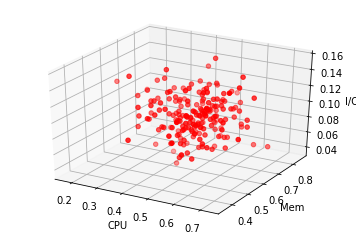

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cpu_loads, mem_loads, io_wait_fraction, c='r', marker='o')
ax.set_xlabel('CPU')
ax.set_ylabel('Mem')
ax.set_zlabel('I/O')
plt.show()

In [65]:
io_wait_fraction[0:3]

array([ 0.06203758,  0.07078969,  0.09149627])

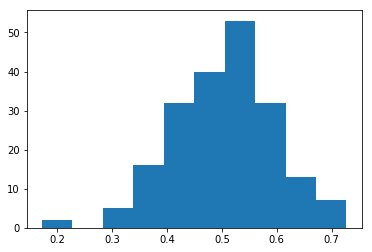

In [66]:
plt.figure()
plt.hist(cpu_loads)
plt.show()

In [67]:
print(cpu_loads.mean())
print(cpu_loads.var())

0.502532835044
0.00823257162491


In [68]:
import matplotlib.mlab as mlab

/Users/ethan/anaconda/envs/grit/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


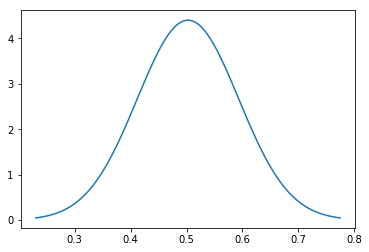

In [69]:
mu = cpu_loads.mean()
sigma = cpu_loads.std()

dx = np.linspace(mu - 3*sigma, mu+3*sigma, 100)

plt.figure()
plt.plot(dx, mlab.normpdf(dx, mu,sigma))
plt.show()

In [70]:
cpu_probs = norm.pdf(cpu_loads, mu, sigma)
mem_probs = norm.pdf(mem_loads, mem_loads.mean(), mem_loads.std())
io_probs = norm.pdf(io_wait_fraction, io_wait_fraction.mean(), io_wait_fraction.std())

In [71]:
sample_probs = cpu_probs * mem_probs * io_probs

In [72]:
sample_probs[0:3]

array([   1.94473285,   91.47404772,  156.17851171])

In [73]:
anomolous_cpu = 0.98
anomolous_mem = 0.96
anomolous_io = 0.4
anomolous_prob = norm.pdf(anomolous_cpu, mu, sigma) * \
  norm.pdf(anomolous_mem, mem_loads.mean(), mem_loads.std()) * \
  norm.pdf(anomolous_io, io_wait_fraction.mean(), io_wait_fraction.std())
print(anomolous_prob)

1.17404891498e-53


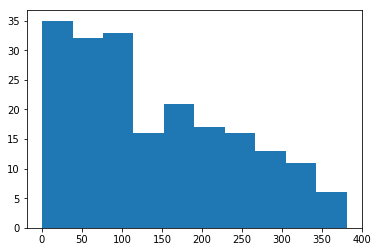

In [74]:
plt.figure()
plt.hist(sample_probs)
plt.show()

In [75]:
sample_probs.min()

0.29737685483812437

In [167]:
class BoxMonitor:
    def __init__(self, cpu_mu, cpu_sig, mem_mu, mem_sig, io_mu, io_sig, threshold):
        self.cm = cpu_mu
        self.cs = cpu_sig
        self.mm = mem_mu
        self.ms = mem_sig
        self.io_m = io_mu
        self.io_s = io_sig
        self.t = threshold
    
    def update_threshold(self, threshold):
        self.t = threshold
    
    def detect(self, cpus, mems, ios):
        cpu_probs = norm.pdf(cpus, self.cm, self.cs)
        mem_probs = norm.pdf(mems, self.mm, self.ms)
        io_probs = norm.pdf(ios, self.io_m, self.io_s)
        sample_probs = cpu_probs * mem_probs * io_probs
        anomaly_indices = sample_probs < self.t
        sample_probs[anomaly_indices] = 1
        sample_probs[~anomaly_indices] = 0
        return sample_probs
    
    def score(self, cpus, mems, ios, y):
        positive_indices = y == 1
        detections = self.detect(cpus, mems, ios)
        detected_indices = detections == 1
        precision = y[detected_indices].sum() / detections.sum()
        recall = detections[positive_indices].sum() / y.sum()
        f1 = 2.0 * ((float(precision) * recall)/ (float(precision) + recall))
        print("Prec: ", precision, "Recall: ", recall, "F1: ", f1)
        return f1
        
        

In [168]:
detector = BoxMonitor(
    cpu_loads.mean(), cpu_loads.std(),
    mem_loads.mean(), mem_loads.std(),
    io_wait_fraction.mean(), io_wait_fraction.std(),
    0.15
)

In [152]:
# synthetic normal data
sample_size = 200
good_cpu_loads = np.random.normal(loc=0.5, scale=0.09, size=sample_size)
good_mem_loads = np.random.normal(loc=0.6, scale=0.09, size=sample_size)
good_io_wait_fraction = np.random.normal(loc=0.1, scale=0.02, size=sample_size)
good_y = np.zeros(sample_size)


In [112]:
detector.detect(good_cpu_loads, good_mem_loads, good_io_wait_fraction)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [163]:
# synthetic anomalous data
sample_size = 10
bad_cpu_loads = np.random.normal(loc=0.8, scale=0.1, size=sample_size)
bad_mem_loads = np.random.normal(loc=0.8, scale=0.04, size=sample_size)
bad_io_wait_fraction = np.random.normal(loc=0.12, scale=0.04, size=sample_size)
bad_y = np.ones(sample_size)


In [164]:
detector.detect(bad_cpu_loads, bad_mem_loads, bad_io_wait_fraction)

array([ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [165]:
test_cpus = np.concatenate([good_cpu_loads, bad_cpu_loads])
test_mems = np.concatenate([good_mem_loads, bad_mem_loads])
test_ios = np.concatenate([good_io_wait_fraction, bad_io_wait_fraction])
test_y = np.concatenate([good_y, bad_y])

THRESHOLD  4.0
Prec:  0.526315789474 Recall:  1.0 F1:  0.689655172414
THRESHOLD  3.0
Prec:  0.588235294118 Recall:  1.0 F1:  0.740740740741
THRESHOLD  2.0
Prec:  0.625 Recall:  1.0 F1:  0.769230769231
THRESHOLD  1.0
Prec:  0.769230769231 Recall:  1.0 F1:  0.869565217391
THRESHOLD  0.5
Prec:  0.833333333333 Recall:  1.0 F1:  0.909090909091
THRESHOLD  0.4
Prec:  0.909090909091 Recall:  1.0 F1:  0.952380952381
THRESHOLD  0.35
Prec:  1.0 Recall:  1.0 F1:  1.0
THRESHOLD  0.3
Prec:  1.0 Recall:  1.0 F1:  1.0
THRESHOLD  0.25
Prec:  1.0 Recall:  1.0 F1:  1.0
THRESHOLD  0.2
Prec:  1.0 Recall:  1.0 F1:  1.0
THRESHOLD  0.15
Prec:  1.0 Recall:  0.9 F1:  0.947368421053
THRESHOLD  0.1
Prec:  1.0 Recall:  0.8 F1:  0.888888888889
THRESHOLD  0.05
Prec:  1.0 Recall:  0.8 F1:  0.888888888889
THRESHOLD  0.01
Prec:  1.0 Recall:  0.8 F1:  0.888888888889


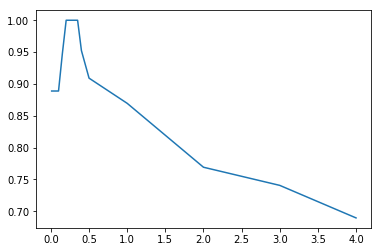

In [172]:
thresholds = [4.0, 3.0, 2.0, 1.0, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
f1s = []
for thresh in thresholds:
    print("THRESHOLD ", thresh)
    detector.update_threshold(thresh)
    f1 = detector.score(test_cpus, test_mems, test_ios, test_y)
    f1s.append(f1)

plt.figure()
plt.plot(thresholds, f1s)
plt.show()

## Autoencoder Anomaly Detection

In [2]:
import scipy.io as sio

In [50]:
#https://archive.ics.uci.edu/ml/datasets/Statlog+%28Landsat+Satellite%29
# Cotton Crop images are the outlier
sat_data = sio.loadmat('satimage-2.mat')
X = sat_data['X']
y = sat_data['y']
print(X.min())
print(X.max())

27.0
157.0


In [51]:
normalized_X = X / 160
print(normalized_X.min())
print(normalized_X.max())

0.16875
0.98125


In [52]:
print(normalized_X.shape)
print(y.shape)

(5803, 36)
(5803, 1)


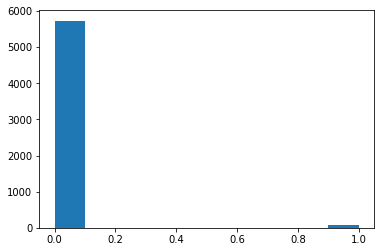

In [12]:
plt.figure()
plt.hist(y)
plt.show()

In [53]:
normal_X = normalized_X[(y == 0.0).reshape(-1)]
anomalous_X = normalized_X[(y == 1.0).reshape(-1)]
print(normal_X.shape)
print(anomalous_X.shape)

(5732, 36)
(71, 36)


In [54]:
normalized_X.shape

(5803, 36)

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(normal_X, test_size=0.20, random_state=1986)
print(X_train.shape)
print(X_test.shape)

(4585, 36)
(1147, 36)


In [31]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [69]:
# https://blog.keras.io/building-autoencoders-in-keras.html
# this is the size of our encoded representations
encoding_dim = 8

# this is our input placeholder
vector_shape = X.shape[1]
input_vec = Input(shape=(vector_shape,))
encoded = Dense(encoding_dim, activation='relu')(input_vec)
decoded = Dense(vector_shape, activation='sigmoid')(encoded)
autoencoder = Model(input_vec, decoded)
# for exploration
encoder = Model(input_vec, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [70]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [72]:
autoencoder.fit(X_train, X_train,
                epochs=1500,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
               verbose=2)

Train on 4585 samples, validate on 1147 samples
Epoch 1/1500
 - 0s - loss: 0.6772 - val_loss: 0.6781
Epoch 2/1500
 - 0s - loss: 0.6770 - val_loss: 0.6779
Epoch 3/1500
 - 0s - loss: 0.6768 - val_loss: 0.6778
Epoch 4/1500
 - 0s - loss: 0.6767 - val_loss: 0.6776
Epoch 5/1500
 - 0s - loss: 0.6765 - val_loss: 0.6774
Epoch 6/1500
 - 0s - loss: 0.6763 - val_loss: 0.6773
Epoch 7/1500
 - 0s - loss: 0.6762 - val_loss: 0.6771
Epoch 8/1500
 - 0s - loss: 0.6760 - val_loss: 0.6769
Epoch 9/1500
 - 0s - loss: 0.6758 - val_loss: 0.6768
Epoch 10/1500
 - 0s - loss: 0.6757 - val_loss: 0.6766
Epoch 11/1500
 - 0s - loss: 0.6755 - val_loss: 0.6765
Epoch 12/1500
 - 0s - loss: 0.6754 - val_loss: 0.6763
Epoch 13/1500
 - 0s - loss: 0.6752 - val_loss: 0.6762
Epoch 14/1500
 - 0s - loss: 0.6751 - val_loss: 0.6760
Epoch 15/1500
 - 0s - loss: 0.6749 - val_loss: 0.6759
Epoch 16/1500
 - 0s - loss: 0.6748 - val_loss: 0.6758
Epoch 17/1500
 - 0s - loss: 0.6747 - val_loss: 0.6756
Epoch 18/1500
 - 0s - loss: 0.6745 - val_lo

 - 0s - loss: 0.6701 - val_loss: 0.6712
Epoch 152/1500
 - 0s - loss: 0.6701 - val_loss: 0.6711
Epoch 153/1500
 - 0s - loss: 0.6701 - val_loss: 0.6711
Epoch 154/1500
 - 0s - loss: 0.6700 - val_loss: 0.6711
Epoch 155/1500
 - 0s - loss: 0.6700 - val_loss: 0.6711
Epoch 156/1500
 - 0s - loss: 0.6700 - val_loss: 0.6711
Epoch 157/1500
 - 0s - loss: 0.6700 - val_loss: 0.6711
Epoch 158/1500
 - 0s - loss: 0.6700 - val_loss: 0.6710
Epoch 159/1500
 - 0s - loss: 0.6699 - val_loss: 0.6710
Epoch 160/1500
 - 0s - loss: 0.6699 - val_loss: 0.6710
Epoch 161/1500
 - 0s - loss: 0.6699 - val_loss: 0.6710
Epoch 162/1500
 - 0s - loss: 0.6699 - val_loss: 0.6710
Epoch 163/1500
 - 0s - loss: 0.6699 - val_loss: 0.6710
Epoch 164/1500
 - 0s - loss: 0.6699 - val_loss: 0.6709
Epoch 165/1500
 - 0s - loss: 0.6698 - val_loss: 0.6709
Epoch 166/1500
 - 0s - loss: 0.6698 - val_loss: 0.6709
Epoch 167/1500
 - 0s - loss: 0.6698 - val_loss: 0.6709
Epoch 168/1500
 - 0s - loss: 0.6698 - val_loss: 0.6709
Epoch 169/1500
 - 0s - lo

 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 301/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 302/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 303/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 304/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 305/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 306/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 307/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 308/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 309/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 310/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 311/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 312/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 313/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 314/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 315/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 316/1500
 - 0s - loss: 0.6685 - val_loss: 0.6697
Epoch 317/1500
 - 0s - loss: 0.6685 - val_loss: 0.6696
Epoch 318/1500
 - 0s - lo

 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 450/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 451/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 452/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 453/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 454/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 455/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 456/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 457/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 458/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 459/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 460/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 461/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 462/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 463/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 464/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 465/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 466/1500
 - 0s - loss: 0.6682 - val_loss: 0.6694
Epoch 467/1500
 - 0s - lo

 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 599/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 600/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 601/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 602/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 603/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 604/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 605/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 606/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 607/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 608/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 609/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 610/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 611/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 612/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 613/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 614/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 615/1500
 - 0s - loss: 0.6680 - val_loss: 0.6692
Epoch 616/1500
 - 0s - lo

 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 748/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 749/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 750/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 751/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 752/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 753/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 754/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 755/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 756/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 757/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 758/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 759/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 760/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 761/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 762/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 763/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 764/1500
 - 0s - loss: 0.6680 - val_loss: 0.6691
Epoch 765/1500
 - 0s - lo

 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 897/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 898/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 899/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 900/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 901/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 902/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 903/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 904/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 905/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 906/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 907/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 908/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 909/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 910/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 911/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 912/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 913/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 914/1500
 - 0s - lo

Epoch 1045/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1046/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1047/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1048/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1049/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1050/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1051/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1052/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1053/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1054/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1055/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1056/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1057/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1058/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1059/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1060/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1061/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1062/1500
 - 0s - loss: 0.6679 - val_loss:

Epoch 1192/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1193/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1194/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1195/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1196/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1197/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1198/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1199/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1200/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1201/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1202/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1203/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1204/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1205/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1206/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1207/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1208/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1209/1500
 - 0s - loss: 0.6679 - val_loss:

Epoch 1339/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1340/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1341/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1342/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1343/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1344/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1345/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1346/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1347/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1348/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1349/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1350/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1351/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1352/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1353/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1354/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1355/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1356/1500
 - 0s - loss: 0.6679 - val_loss:

Epoch 1486/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1487/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1488/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1489/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1490/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1491/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1492/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1493/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1494/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1495/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1496/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1497/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1498/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1499/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691
Epoch 1500/1500
 - 0s - loss: 0.6679 - val_loss: 0.6691


In [77]:
encoded_vectors = encoder.predict(normal_X)
decoded_vectors = decoder.predict(encoded_vectors)

In [78]:
normal_X[0]

array([ 0.575  ,  0.71875,  0.75   ,  0.5875 ,  0.525  ,  0.6375 ,
        0.6625 ,  0.49375,  0.525  ,  0.6375 ,  0.6375 ,  0.51875,
        0.63125,  0.7875 ,  0.83125,  0.64375,  0.575  ,  0.7    ,
        0.7375 ,  0.53125,  0.525  ,  0.64375,  0.65   ,  0.50625,
        0.6375 ,  0.7875 ,  0.8375 ,  0.65   ,  0.55   ,  0.75625,
        0.8    ,  0.625  ,  0.525  ,  0.66875,  0.70625,  0.54375])

In [79]:
encoded_vectors[0]

array([ 0.        ,  1.7487061 ,  0.        ,  0.        ,  0.        ,
        1.63671219,  1.1890204 ,  0.        ], dtype=float32)

In [80]:
decoded_vectors[0]

array([ 0.5416339 ,  0.66619956,  0.6855045 ,  0.53678429,  0.54136014,
        0.6664384 ,  0.68454337,  0.53553003,  0.53921014,  0.66403192,
        0.68339998,  0.53698766,  0.56563073,  0.70616549,  0.72423583,
        0.57170165,  0.56918687,  0.71155047,  0.72720921,  0.57366449,
        0.56544495,  0.70665199,  0.72234094,  0.56910616,  0.58459783,
        0.73821795,  0.75265926,  0.59719223,  0.58912164,  0.74562353,
        0.75799894,  0.60150731,  0.58253938,  0.73582256,  0.7501778 ,
        0.5935393 ], dtype=float32)

In [83]:
np.square(decoded_vectors[0] - normal_X[0]).mean()

0.0025859118447522215

In [84]:
encoded_anomolies = encoder.predict(anomalous_X)
decoded_anomolies = decoder.predict(encoded_anomolies)

In [85]:
anomalous_X[0]

array([ 0.3125 ,  0.19375,  0.83125,  0.84375,  0.3125 ,  0.19375,
        0.8    ,  0.825  ,  0.2875 ,  0.2125 ,  0.8    ,  0.84375,
        0.275  ,  0.2    ,  0.8375 ,  0.85625,  0.3    ,  0.2125 ,
        0.8    ,  0.83125,  0.3    ,  0.2    ,  0.8375 ,  0.83125,
        0.2875 ,  0.2    ,  0.83125,  0.85   ,  0.2875 ,  0.2    ,
        0.79375,  0.85   ,  0.30625,  0.2    ,  0.79375,  0.83125])

In [86]:
encoded_anomolies[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.94588339,  2.42730474,  0.        ], dtype=float32)

In [87]:
decoded_anomolies[0]

array([ 0.24164747,  0.56452847,  0.77659464,  0.68957329,  0.2427216 ,
        0.5671494 ,  0.78297591,  0.69726717,  0.24599798,  0.56635761,
        0.78019512,  0.69445509,  0.22758988,  0.5340035 ,  0.75594366,
        0.67165226,  0.22900307,  0.54047316,  0.76225412,  0.67859089,
        0.2343051 ,  0.54394776,  0.76516902,  0.68063575,  0.21603878,
        0.49571359,  0.7341789 ,  0.65958089,  0.21549185,  0.50093037,
        0.74013782,  0.66354179,  0.22212918,  0.51429582,  0.74520355,
        0.66716158], dtype=float32)

In [88]:
np.square(decoded_anomolies[0] - anomalous_X[0]).mean()

0.036914947676888549

In [93]:
normal_mse = np.square(decoded_vectors - normal_X).mean(axis=1)
anomaly_mse = np.square(decoded_anomolies - anomalous_X).mean(axis=1)

In [95]:
normal_mse.shape

(5732,)

In [91]:
np.square(decoded_vectors - normal_X).shape

(5732, 36)

In [92]:
np.square(decoded_vectors - normal_X).mean(axis=1).shape

(5732,)

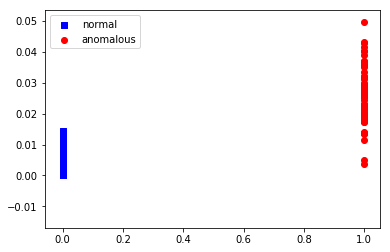

In [96]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(np.zeros(normal_mse.shape[0]), normal_mse, c='b', marker="s", label='normal')
ax1.scatter(np.ones(anomaly_mse.shape[0]), anomaly_mse, c='r', marker="o", label='anomalous')
plt.legend(loc='upper left');
plt.show()